In [65]:
#0!pip install procrustes
#!pip install scikit-procrustes

def procrustes(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy.

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)

    Inputs:
    ------------
    X, Y    
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.

    scaling 
        if False, the scaling component of the transformation is forced
        to 1

    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.

    Outputs
    ------------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection is not 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2
        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)
    #rot =1
    #scale=2
    #translate=3
    #transformation values 
    tform = {'rotation':T, 'scale':b, 'translation':c}

    return d, Z, tform

In [66]:
#import skprocrustes as pc 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import cv2
#from scipy.spatial import procrustes

In [67]:
target_X_img = cv2.imread('jpg/ct.jpg',0)
input_Y_img = cv2.imread('jpg/mri.jpg',0)


In [68]:
X_pts = np.asarray([[61,61],[142,62],[101,104],[71,143],[140,139]])
Y_pts = np.asarray([[106,91],[147,95],[129,111],[104,130],[141,135]])

In [69]:
#Tform,Z_pts,d= procrustes(X_pts,Y_pts)
d,Z_pts,Tform = procrustes(X_pts,Y_pts)

In [70]:
R = np.eye(3)

In [71]:
Tform

{'rotation': array([[ 0.99007107, -0.14056767],
        [ 0.14056767,  0.99007107]]),
 'scale': 1.9427385507730361,
 'translation': array([-168.89542733,  -80.15068144])}

In [72]:
R[0:2,0:2] = Tform['rotation']

In [73]:
S = np.eye(3) * Tform['scale'] 
S[2,2] = 1
t = np.eye(3)
t[0:2,2] = Tform['translation']
M = np.dot(np.dot(R,S),t.T).T
tr_Y_img = cv2.warpAffine(input_Y_img,M[0:2,:],(400,400))

In [74]:
aY_pts = np.hstack((Y_pts,np.array(([[1,1,1,1,1]])).T))
tr_Y_pts = np.dot(M,aY_pts.T).T

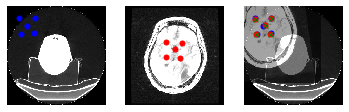

In [75]:
plt.figure() 
plt.subplot(1,3,1)
plt.imshow(target_X_img,cmap=cm.gray)
plt.plot(X_pts[:,0],X_pts[:,1],'bo',markersize=5)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(input_Y_img,cmap=cm.gray)
plt.plot(Y_pts[:,0],Y_pts[:,1],'ro',markersize=5)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(target_X_img,cmap=cm.gray)
plt.imshow(tr_Y_img,alpha=0.6,cmap=cm.gray)
plt.plot(X_pts[:,0],X_pts[:,1],'bo',markersize=5) 
plt.plot(Z_pts[:,0],Z_pts[:,1],'ro',markersize=5) # same as...
plt.plot(tr_Y_pts[:,0],tr_Y_pts[:,1],'gx',markersize=5)
plt.axis('off')
plt.show()